#### Загрузка библиотек и необходимых модулей

In [13]:
options(warn=-1)

In [14]:
library(dplyr)
library(ggplot2)
library(survival)
library(survminer)
library(rms)
library(repr)

In [50]:
#get list of files in working directory
print(list.files("data"))

[1] "cookie_cats.csv"  "online.csv"       "survivalData.csv"


In [51]:
dataNextOrder <- read.csv("data/survivalData.csv")
str(dataNextOrder)
head(dataNextOrder)

'data.frame':	5122 obs. of  6 variables:
 $ daysSinceFirstPurch: int  37 63 48 17 53 11 22 16 74 44 ...
 $ shoppingCartValue  : num  33.4 31.7 27.3 41.1 65.6 ...
 $ gender             : Factor w/ 2 levels "female","male": 2 2 1 2 1 1 1 1 1 1 ...
 $ voucher            : int  0 1 0 0 0 0 0 1 0 0 ...
 $ returned           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ boughtAgain        : int  0 1 0 1 0 1 1 1 0 1 ...


daysSinceFirstPurch,shoppingCartValue,gender,voucher,returned,boughtAgain
37,33.44,male,0,0,0
63,31.71,male,1,0,1
48,27.31,female,0,0,0
17,41.07,male,0,0,1
53,65.56,female,0,0,0
11,38.44,female,0,0,1


# Анализ выживаемости
__Анализ выживаемости__ (англ. survival analysis) — класс статистических моделей, позволяющих оценить вероятность наступления события в данном случае интересующим нас событием является время до следующего заказа/покупки.

#### Примеры использования Анализа выживаемости в Системе управления взаимоотношениями с клиентами
Анализ выживаемости позволяет ответить на следующие вопросы:
<pr>__Пример.1:__ В течение какого времени клиент совершит повторный заказ 
<br>__Пример.2:__ Разорвет ли клиент контракт в течение следующих 3 месяцев 
    
## Ключевые моменты при проведении анализа выживаемости
В отличие от Логистической регрессии, которая применяется с целью предсказать вероятность интересующего нас события,
Анализ выживаемости позволяет нам предсказать так называемое "время выживаемости" момент когда интересующее нас событие наступит.
<pr>Анализ выживаемости используется в ситуациях когда интересующее нас событие не случилось, но может произойти в какой-то определенный момент в будущем.
<pr>Информация, которая у нас есть в момент проведения Анализа выживаемости: случилось ли интересующее нас событие или нет. При этом мы не знаем наступит ли интересующее нас событие завтра или в течении 3 лет.

### Первичный анализ данных
__категориальные переменные:__
* __boughtAgain__ принимает значение 0 если клиент совершил лишь один заказ и 1 для покупателей, которые уже совершили вторую покупку
* __daysSinceFirstPurch__ кол-во дней между первым и вторым заказом, если клиент совершил заказ во второй раз 
* __voucher__ использовал или нет клиент скидочный купон в момент первого заказа
* __gender__ пол клиента
* __returned__ был ли осуществлен возврат товара  

__непрерывные переменные:__
* __shoppingCartValue__ сумма заказа

<pr>Для клиентов, которые не совершили второй заказ, переменная __daysSinceFirstPurch__ содержит время со дня их первого заказа.

In [17]:
summary(dataNextOrder)

 daysSinceFirstPurch shoppingCartValue    gender        voucher      
 Min.   :  1.00      Min.   : 17.35    female:3247   Min.   :0.0000  
 1st Qu.: 21.00      1st Qu.: 54.43    male  :1875   1st Qu.:0.0000  
 Median : 33.00      Median : 76.56                  Median :0.0000  
 Mean   : 34.95      Mean   : 91.81                  Mean   :0.2021  
 3rd Qu.: 46.00      3rd Qu.:110.61                  3rd Qu.:0.0000  
 Max.   :144.00      Max.   :914.04                  Max.   :1.0000  
    returned      boughtAgain    
 Min.   :0.000   Min.   :0.0000  
 1st Qu.:0.000   1st Qu.:0.0000  
 Median :0.000   Median :1.0000  
 Mean   :0.204   Mean   :0.6246  
 3rd Qu.:0.000   3rd Qu.:1.0000  
 Max.   :1.000   Max.   :1.0000  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


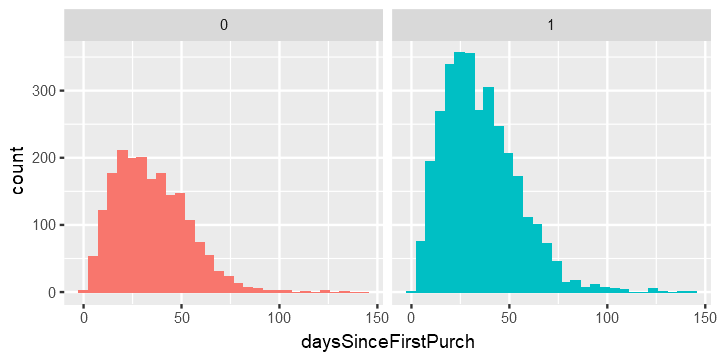

In [18]:
library(repr)
options(repr.plot.width=6, repr.plot.height=3)


options(warn=-1)
ggplot(dataNextOrder) +
  geom_histogram(aes(x = daysSinceFirstPurch,
                     fill = factor(boughtAgain))) +
  facet_grid( ~ boughtAgain) + 
  theme(legend.position = "none") 

 __Как видно из двух графиков распределения большинство клиентов в представленных данных совершили повторных заказ. __

## Основные методы, используемые при проведении Анализа выживаемости
### Функция выживаемости, функция распределения и  отношение рисков 
* __Функция выживаемости (Survival function):__ вероятность что мы не потеряем клиента до определенного момента t в будущем
    <pr> Функция выживаемости описывает часть клиентов, которых мы еще не потеряли в зависимости от времени в течении, которого мы наблюдаем за ними. 


* __Кумулятивная функция распределения (Cumulative hazard function):__ кумулятивный риск или вероятность, что мы потеряем клиента в определенный момент t в будущем 

    
* __Отношение рисков (Hazard Rate):__ описывает риск того что интересующее нас событие случиться в течение небольшого промежутка времени в будущем и мы обладаем информацией что данное событие еще не наступило
    <pr> Отношение рисков может меняться во временем либо увеличиваться, либо уменьшаться. Например, вероятность того, что мы потеряем клиента в самом начале (после первого заказа) намного выше, чем по истечении нескольких месяцев, и затем опять увеличивается по истечение определенного времени вследствие эффекта насыщения. 
    
<pr> __В данном анализе будет использован первый метод - Функция выживаемости (Survival function) с использованием оценки Каплана—Мейера__.

### Функция выживаемости с использованием оценки Каплана—Мейера

<pr> Основное понятие так называемая "группа риска": покупатели, которые все еще являются нашими клиентами, но которых мы можем потерять в будущем<pr>
<pr>Основные шаги при построении Функции выживаемости:
* 1 шаг создание так называемого Survival Object при помощи __Surv()__ функции
* 2 шаг расчет "группы риска" для дальнейшего построения графика выживаемости при помощи __survfit()__ функции   


#### Survival object
Survival object представляет собой промаркированное время, которое содержиться в переменной daysSinceFirstPurch и является количеством дней с момента последнего заказа. В данном случае маркер + означает, что повторный заказ в настоящий момент не совершен покупателем.

In [26]:
survObj <- Surv(dataNextOrder$daysSinceFirstPurch, dataNextOrder$boughtAgain)
str(survObj)

 'Surv' num [1:5122, 1:2]  37+  63   48+  17   53+  11   22   16   74+  44  ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "time" "status"
 - attr(*, "type")= chr "right"


### Каплан—Мейер Анализ
* __Каплан—Мейер Анализ без ковариации(без взаимосвязи с другими параметрами):__ survfit(Survival object ~ 1)
* __Каплан—Мейер Анализ с ковариацией (взаимосвязь с категориальными переменными):__ survfit(Survival object ~ независимые категориальные переменные)

### Каплан—Мейер Анализ без ковариации (без взаимосвязи с другими параметрами)

Call: survfit(formula = survObj ~ 1)

      n  events  median 0.95LCL 0.95UCL 
   5122    3199      41      40      42 


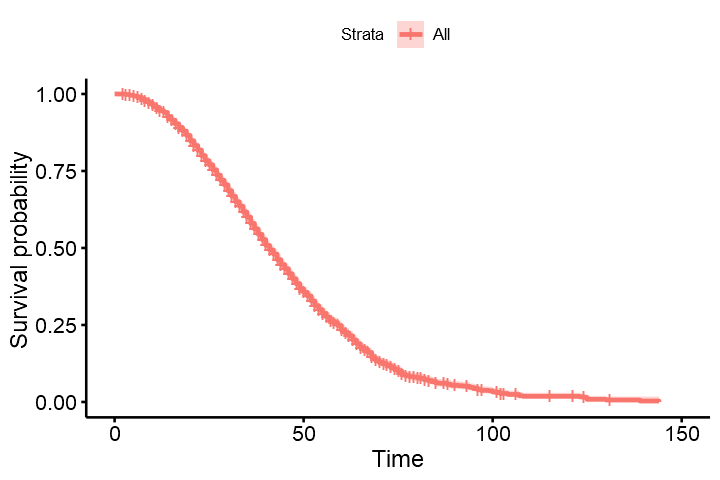

In [28]:
options(repr.plot.width=6, repr.plot.height=4)

fitKMSimple <- survfit(survObj ~ 1)
print(fitKMSimple)

ggsurvplot(fitKMSimple, data = dataNextOrder, pval = TRUE)

### Каплан—Мейер Анализ с ковариацией (взаимосвязь с категориальными переменными)
в данном случае мы проанализируем как влияет использование ваучера при первом заказе на повторный заказ 

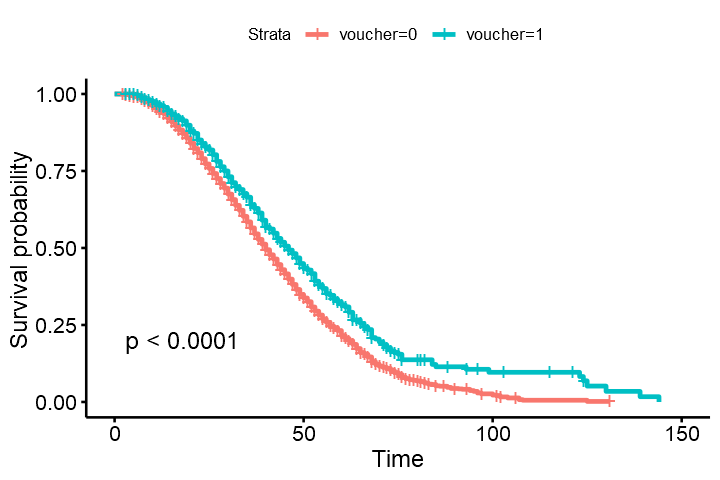

In [29]:
options(repr.plot.width=6, repr.plot.height=4)

fitKMCov <- survfit(survObj ~ voucher, data = dataNextOrder)

ggsurvplot(fitKMCov, data = dataNextOrder, pval = TRUE)

Согласно построенному выше графику (Survive function),что у  клиентов, которые воспользовались скидкой при совершении первого заказа, время по прошествии  которого они делают повторные заказ намного больше чем у клиентов, которые не использовали скидочный купон. Вероятное объяснение, что возможно перед совершением повторного заказа, они некоторое время ожидают повторное предоставление скидки.

## Cox proportional Hazard модель (Cox PH модель) с постоянной ковариацией
После того, как мы проанализировали вероятность того, что мы не потеряем клиента до определенного момента t в будущем при помощи Функции выживаемости с использованием оценки Каплана—Мейера, мы можем построить модель, которая позволит нам с большой долей вероятность предсказать когда клиент совершит повторный заказ. 
<pr>При построении данной модели вероятность выживаемости (в нашем случае вероятность совершения повторного заказа) зависит от различных уровней одного параметра (независимой переменной), при этом значение всех остальных коэффициентов остается неизменным.

__Основным предположением при построении данной модели является:__ влияние параметров, на основе которых мы строим модель, не изменяются со временем.
<pr>__Пример.:__ при использовании параметра gender при построении данной модели не допускается, что данный параметр имеет положительный эффект на время выживания (в нашем случае время через которое будет осуществлен повторный заказа) в течение короткого промежутке времени, но на большем промежутке времени будет иметь негативное влияние.

In [33]:
fitCPH <- coxph(Surv(daysSinceFirstPurch, boughtAgain) ~ shoppingCartValue + voucher + returned + gender,
                      data = dataNextOrder)

print(fitCPH)

Call:
coxph(formula = Surv(daysSinceFirstPurch, boughtAgain) ~ shoppingCartValue + 
    voucher + returned + gender, data = dataNextOrder)

                       coef exp(coef)  se(coef)      z        p
shoppingCartValue -0.002164  0.997838  0.000284 -7.619 2.56e-14
voucher           -0.294615  0.744819  0.047969 -6.142 8.16e-10
returned          -0.314829  0.729914  0.049470 -6.364 1.97e-10
gendermale         0.108263  1.114341  0.036323  2.981  0.00288

Likelihood ratio test=155.7  on 4 df, p=< 2.2e-16
n= 5122, number of events= 3199 


#### Интерпретация коэффициентов построенной модели

In [34]:
exp(fitCPH$coefficients)

shoppingCartValue           voucher          returned        gendermale 
        0.9978385         0.7448187         0.7299136         1.1143414

в данном случае все коэффициенты являются статистически значимыми, т.е. время повторного заказа зависит от всех переменных на основе которых мы построили нашу модель: shoppingCartValue, voucher, returned, gender.


* увеличение стоимости корзины на $1 уменьшает шанс повторного заказа на значение чуть меньше 1;
<br>


* шанс, что клиенты, кто воспользовался ваучером в момент первого заказа, совершат повторный заказ меньше по сравнению с теми клиентами, кто заказ не совершал и составляет 0.74;
<br>



* шансы что клиент, который осуществил возврат товара после первого заказа, совершит повторный заказа меньше по сравнению с теми клиентами, кто товар не возвращал и составляет 0.73;
<br>



* шансы что клиенты, являющиеся мужчинами, совершат повторный заказ выше по сравнению с клиентами женского пола и составляет 1.11

#### Визуализация построенной модели

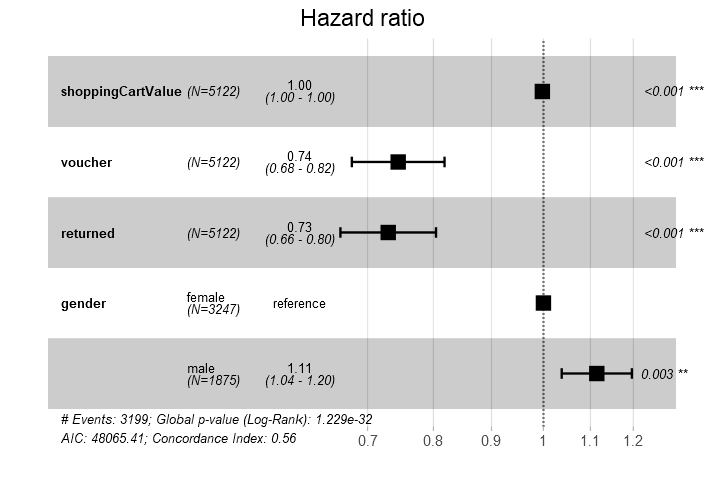

In [35]:
ggforest(fitCPH, data = dataNextOrder)

## Оценка построенной модели
####  Оценка модели производится в два этапа
* Проверяется было ли соблюдено ключевое требование: влияние параметров, на основе которых мы строим модель, не должны изменяться со временем.
* Так же производиться оценка модели при помощи перекрестной проверки (cross-validation)

In [40]:
fitCPH <- cph(Surv(daysSinceFirstPurch, boughtAgain) ~ shoppingCartValue + voucher + returned + gender,
              data = dataNextOrder,
              x = TRUE, y = TRUE, surv = TRUE)

testCPH <- cox.zph(fitCPH)
print(testCPH)

                      rho chisq      p
shoppingCartValue -0.0168 0.907 0.3409
voucher           -0.0155 0.770 0.3803
returned           0.0261 2.182 0.1397
gender=male        0.0390 4.922 0.0265
GLOBAL                 NA 8.528 0.0740


В данном случае один из параметров пол покупателя (gender=male) нарушает данное требование, если в качестве критерия значимости (p-value) мы будем использовать значение 0.05.

#### Визуальный анализ параметра, влияние которого может изменять с течением времени

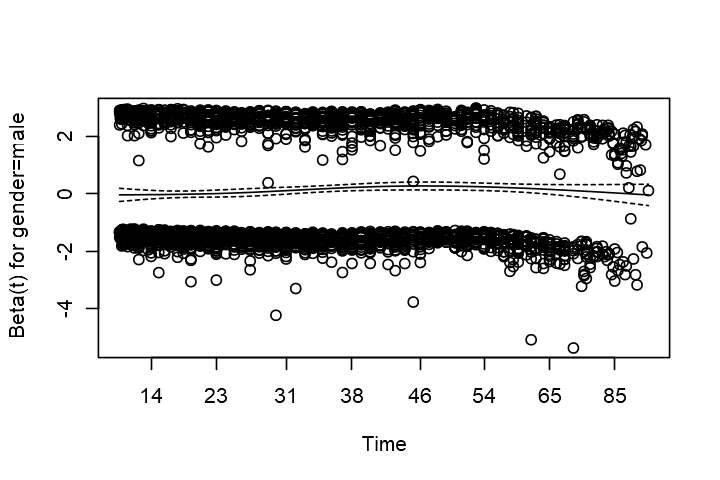

In [41]:
plot(testCPH, var = "gender=male")

#### Оценка модели при помощи перекрестной проверки (cross-validation)

In [42]:
validate(fitCPH, method = "crossvalidation",
         B = 10, dxy = TRUE, pr = FALSE)

      index.orig training   test optimism index.corrected  n
Dxy       0.1159   0.1161 0.1130   0.0032          0.1127 10
R2        0.0299   0.0300 0.0286   0.0014          0.0285 10
Slope     1.0000   1.0000 0.9562   0.0438          0.9562 10
D         0.0032   0.0033 0.0042  -0.0009          0.0041 10
U         0.0000   0.0000 0.0002  -0.0003          0.0002 10
Q         0.0032   0.0033 0.0039  -0.0006          0.0039 10
g         0.2380   0.2383 0.2288   0.0095          0.2286 10

К сожалению, точность данной модели не высоко значение квадратичной ошибки достаточно высоко и составляет R2 =      0.0299 . В данном случае мы можем попробовать улучшить нашу модель путем сбора дополнительной информации (дополнительных параметров).

## Построение прогноза на основе новых данных с использованием Cox PH модели
В данном случае пред нами стоит следующая задача: сделать прогноз для двух новых клиентов с использованием Cox PH модели в течение какого промежутка времени будет совершен повторный заказ и построить график. 

* newCustomer1:
    <pr>Новый клиент женщина, которая воспользовалась скидочным купоном в момент заказа (voucher = 1). Заказ был сделан 21 день назад и стоимость заказа составила $99.90. Клиент не осуществлял возврат товара (returned = 0).


* newCustomer2:
    <pr>Новый клиент мужчина, который воспользовался скидочным купоном в момент заказа (voucher = 1). Заказ был сделан 21 день назад и стоимость заказа составила $99.90. Клиент не осуществлял возврат товара (returned = 0).

Call: survfit(formula = fitCPH, newdata = newCustomer)

      n  events  median 0.95LCL 0.95UCL 
   5122    3199      47      44      49 


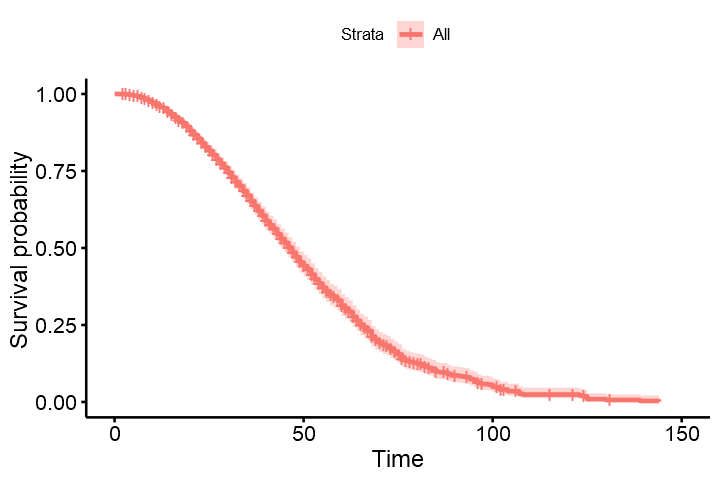

In [46]:
newCustomer <- data.frame(daysSinceFirstPurch = 21, shoppingCartValue = 99.90, gender = "female", voucher = 1, returned = 0, stringsAsFactors = FALSE)

pred <- survfit(fitCPH, newdata = newCustomer)
print(pred)

ggsurvplot(survfit(fitCPH, newdata = newCustomer), data = newCustomer, pval = TRUE)

Call: survfit(formula = fitCPH, newdata = newCustomer2)

      n  events  median 0.95LCL 0.95UCL 
   5122    3199      44      42      47 


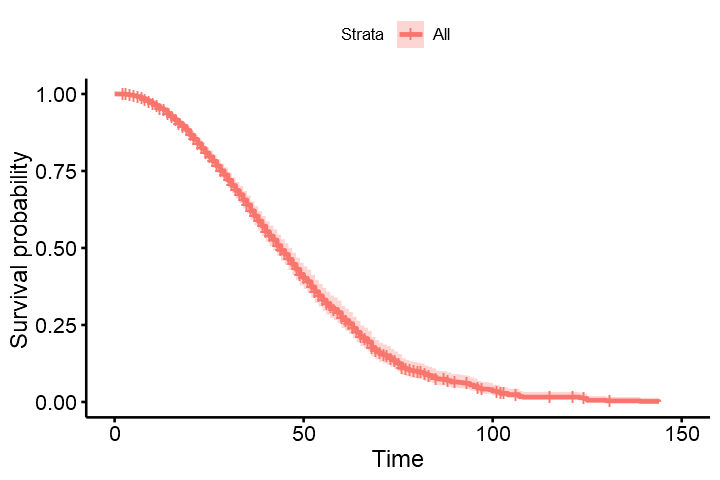

In [48]:
newCustomer2 <- newCustomer
newCustomer2$gender <- 'male'

pred2 <- survfit(fitCPH, newdata = newCustomer2)
print(pred2)

ggsurvplot(survfit(fitCPH, newdata = newCustomer2), data = newCustomer, pval = TRUE)

#### Вывод на основе сделанного прогноза
На основе данного прогноза для двух новых клиентов, мы можем сделать вывод, что при прочих абсолютно равны условиях, в зависимости от пола клиента медианное значение времени до второго заказа составляет для клиента женского пола 47 дней и для клиента мужского пола 44 дня.